# Lesson - Building and Organizing Complex Quries in SQL
In this lesson, we will practice constructing complex joins, while also learning how to:

- Build and format queries for readability
- Creating named subqueries and views
- Combining data using set operations.

We will work with `chinook` database for which schema diagram is given below:
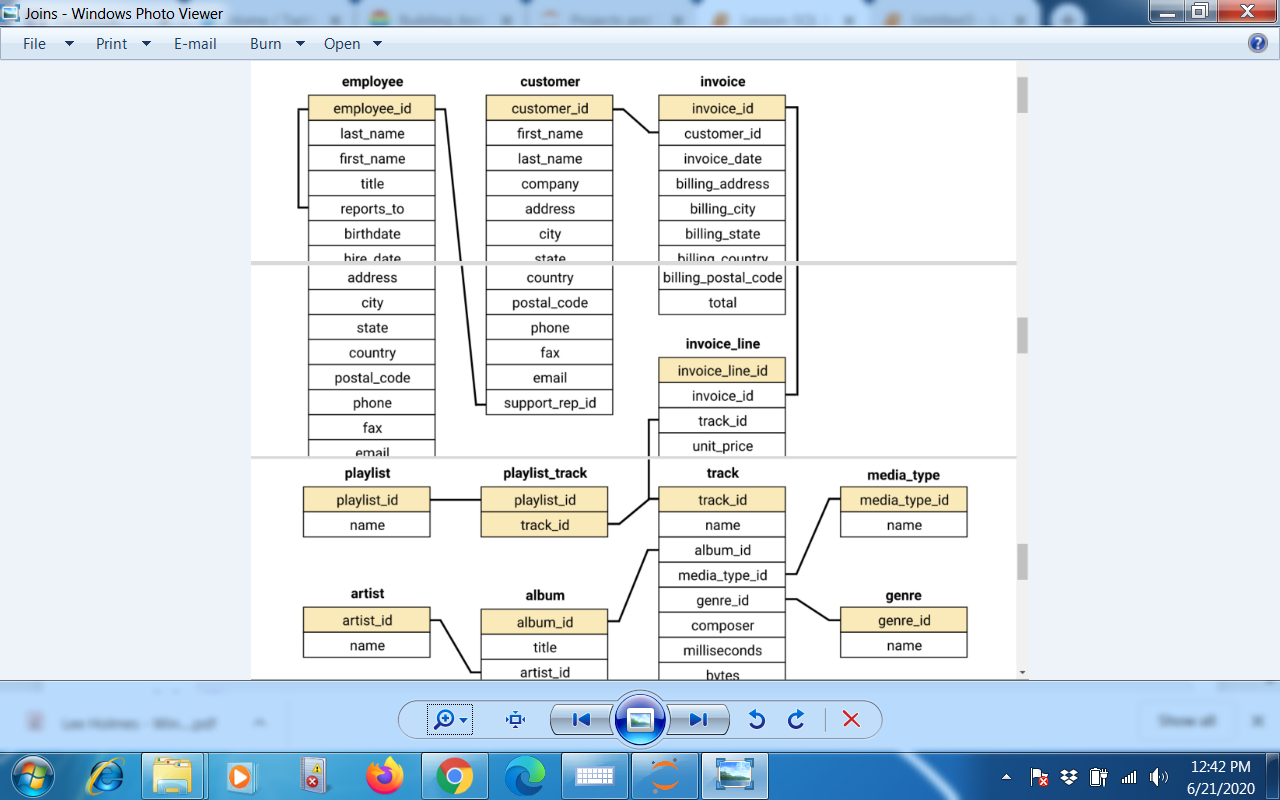

**Load sql and connect to the Database factbook.db using following magic:**

In [48]:
%%capture
%reload_ext sql
%sql sqlite:///chinook.db    

### Query the database to get table information for `chinook.db` directly:
**Use %%sql magic before query in each code cell to avoid returning an error 

In [49]:
%%sql
SELECT * 
FROM sqlite_master 
WHERE type='table';

 * sqlite:///chinook.db
Done.


type,name,tbl_name,rootpage,sql
table,album,album,2,"CREATE TABLE [album]( [album_id] INTEGER PRIMARY KEY NOT NULL, [title] NVARCHAR(160) NOT NULL, [artist_id] INTEGER NOT NULL, FOREIGN KEY ([artist_id]) REFERENCES [artist] ([artist_id]) ON DELETE NO ACTION ON UPDATE NO ACTION)"
table,artist,artist,3,"CREATE TABLE [artist]( [artist_id] INTEGER PRIMARY KEY NOT NULL, [name] NVARCHAR(120))"
table,customer,customer,4,"CREATE TABLE [customer]( [customer_id] INTEGER PRIMARY KEY NOT NULL, [first_name] NVARCHAR(40) NOT NULL, [last_name] NVARCHAR(20) NOT NULL, [company] NVARCHAR(80), [address] NVARCHAR(70), [city] NVARCHAR(40), [state] NVARCHAR(40), [country] NVARCHAR(40), [postal_code] NVARCHAR(10), [phone] NVARCHAR(24), [fax] NVARCHAR(24), [email] NVARCHAR(60) NOT NULL, [support_rep_id] INTEGER, FOREIGN KEY ([support_rep_id]) REFERENCES [employee] ([employee_id]) ON DELETE NO ACTION ON UPDATE NO ACTION)"
table,employee,employee,5,"CREATE TABLE [employee]( [employee_id] INTEGER PRIMARY KEY NOT NULL, [last_name] NVARCHAR(20) NOT NULL, [first_name] NVARCHAR(20) NOT NULL, [title] NVARCHAR(30), [reports_to] INTEGER, [birthdate] DATETIME, [hire_date] DATETIME, [address] NVARCHAR(70), [city] NVARCHAR(40), [state] NVARCHAR(40), [country] NVARCHAR(40), [postal_code] NVARCHAR(10), [phone] NVARCHAR(24), [fax] NVARCHAR(24), [email] NVARCHAR(60), FOREIGN KEY ([reports_to]) REFERENCES [employee] ([employee_id]) ON DELETE NO ACTION ON UPDATE NO ACTION)"
table,genre,genre,6,"CREATE TABLE [genre]( [genre_id] INTEGER PRIMARY KEY NOT NULL, [name] NVARCHAR(120))"
table,invoice,invoice,7,"CREATE TABLE [invoice]( [invoice_id] INTEGER PRIMARY KEY NOT NULL, [customer_id] INTEGER NOT NULL, [invoice_date] DATETIME NOT NULL, [billing_address] NVARCHAR(70), [billing_city] NVARCHAR(40), [billing_state] NVARCHAR(40), [billing_country] NVARCHAR(40), [billing_postal_code] NVARCHAR(10), [total] NUMERIC(10,2) NOT NULL, FOREIGN KEY ([customer_id]) REFERENCES [customer] ([customer_id]) ON DELETE NO ACTION ON UPDATE NO ACTION)"
table,invoice_line,invoice_line,8,"CREATE TABLE [invoice_line]( [invoice_line_id] INTEGER PRIMARY KEY NOT NULL, [invoice_id] INTEGER NOT NULL, [track_id] INTEGER NOT NULL, [unit_price] NUMERIC(10,2) NOT NULL, [quantity] INTEGER NOT NULL, FOREIGN KEY ([invoice_id]) REFERENCES [invoice] ([invoice_id]) ON DELETE NO ACTION ON UPDATE NO ACTION, FOREIGN KEY ([track_id]) REFERENCES [track] ([track_id]) ON DELETE NO ACTION ON UPDATE NO ACTION)"
table,media_type,media_type,9,"CREATE TABLE [media_type]( [media_type_id] INTEGER PRIMARY KEY NOT NULL, [name] NVARCHAR(120))"
table,playlist,playlist,10,"CREATE TABLE [playlist]( [playlist_id] INTEGER PRIMARY KEY NOT NULL, [name] NVARCHAR(120))"
table,playlist_track,playlist_track,11,"CREATE TABLE [playlist_track]( [playlist_id] INTEGER NOT NULL, [track_id] INTEGER NOT NULL, CONSTRAINT [pk_playlist_track] PRIMARY KEY ([playlist_id], [track_id]), FOREIGN KEY ([playlist_id]) REFERENCES [playlist] ([playlist_id]) ON DELETE NO ACTION ON UPDATE NO ACTION, FOREIGN KEY ([track_id]) REFERENCES [track] ([track_id]) ON DELETE NO ACTION ON UPDATE NO ACTION)"


### Writing Readable Queries

Taking the time to write queries to be more easily understood will take a little extra time now, but will save you time when you come back to old queries that you have written, and help your colleagues when you're working in a data team.

One obvious area when it comes to writing queries is the use of **capitalization and whitespace**. Because white space doesn't have any meaning in SQL, it can be used to help convey meaning in a complex query. Let's compare the same query written twice— first without whitespace and capitalization:

```
select ta.artist_name artist, count(*) tracks_sold from invoice_line il
inner join (select t.track_id, ar.name artist_name from track t
inner join album al on al.album_id = t.album_id
inner join artist ar on ar.artist_id = al.artist_id) ta
on ta.track_id = il.track_id group by 1 order by 2 desc limit 10;

```
And now, with whitespace and capitalization:

```
SELECT
    ta.artist_name artist,
    COUNT(*) tracks_sold
FROM invoice_line il
INNER JOIN (
            SELECT
                t.track_id,
                ar.name artist_name
            FROM track t
            INNER JOIN album al ON al.album_id = t.album_id
            INNER JOIN artist ar ON ar.artist_id = al.artist_id
           ) ta
           ON ta.track_id = il.track_id
GROUP BY 1
ORDER BY 2 DESC LIMIT 10;

```

As you can see, a little time put into whitespace and capitalization pays off. A few tips to help make  queries more readable:

- If a select statement has more than one column, put each on a new line, indented from the select statement.
- Always capitalize SQL function names and keywords
- Put each clause of query on a new line.
- Use indenting to make subqueries appear logically separate.

Another important consideration when writing readable queries is the use of alias names and shortcuts. Name aliases should be clear– a common convention is using the first letter of the table name, however if you feel that a query is complex you should consider using more explicit aliases. Similarly, at times lines like GROUP BY 1 can be confusing, and explicitly naming the column will make your query more readable.

If you work in a team, you might consider a SQL style guide— a great guide is available at [SQL style guide](https://www.sqlstyle.guide/), but remember that readability is more important than consistency. If you have a complex query and you think breaking the style guide will make it more readable, you should do it.

### The WITH Clause
When constructing complex queries, it's useful to create an intermediate table to produce our final results. You can use subqueries to create these intermediate tables. Unfortunately, the way subqueries are written makes it harder to read— the person reading the query needs to find the subquery and read from the inside-out.

Syntax:
```
WITH [alias_name] AS ([subquery])

SELECT [main_query]

```

Write a query:
- that shows summary data for every playlist in the Chinook database:
Use a `WITH` clause to create a named `subquery` with the following info:
- The unique ID for the playlist.
- The name of the playlist.
- The name of each track from the playlist.
- The length of each track in seconds.
- Your final table should have the following columns, in order:
 - `playlist_id` - the unique ID for the playlist.
 - `playlist_name` - The name of the playlist.
 - `number_of_tracks` - A count of the number of tracks in the playlist.
 - `length_seconds` - The sum of the length of the playlist in seconds.
The results should be sorted by playlist_id in ascending order.

In [3]:
%%sql
WITH pl AS
          (
           SELECT
           p.playlist_id,
           p.name AS playlist_name,
           t.name AS track,
           (t.milliseconds/1000) AS length
      FROM playlist AS p
           LEFt JOIN playlist_track AS pt ON pt.playlist_id = p.playlist_id
           LEFt JOIN track AS t ON t.track_id = pt.track_id     
           )
SELECT 
    pl.playlist_id,
    playlist_name,
    COUNT(track),
    SUM(length) AS length_seconds
 FROM pl

GROUP BY 1, 2
ORDER BY 1;

 * sqlite:///chinook.db
Done.


playlist_id,playlist_name,COUNT(track),length_seconds
1,Music,3290,876049
2,Movies,0,None
3,TV Shows,213,500987
4,Audiobooks,0,None
5,90’s Music,1477,397970
6,Audiobooks,0,None
7,Movies,0,None
8,Music,3290,876049
9,Music Videos,1,294
10,TV Shows,213,500987


### Creating a View
Subqueries created with `WITH` clause can only be used within that query. By creating a `VIEW`, we can  use subqueries in all future queries. 

Syntax (if database manually attached):
```
CREATE VIEW database.view_name AS
    SELECT * FROM database.table;
```
Syntax (for auto database e.g. in jupyter):

```
CREATE VIEW view_name AS
    SELECT * FROM table;
    
```
Create a `VIEW` `customer2`from `chinook` database identical to `customer` table:
```
CREATE VIEW chinook.customer_2 AS
    SELECT * 
      FROM chinook.customer
``` 
OR simply ` CREATE VIEW customer_2 AS
            SELECT * FROM customer;` if working from jupyter
            
Once created, VIEW cannot be amended it has to be dropped:
```
DROP VIEW customer_2; "OR chinook.customer-2"

```

Create a view of all customers from USA:
```
CREATE VIEW customer_usa AS
SELECT * 
  FROM customer
WHERE country = "USA";

C

- 


In [4]:
%%sql
CREATE VIEW customer_usa AS
     SELECT * 
       FROM customer
     WHERE country = "USA";

 * sqlite:///chinook.db
(sqlite3.OperationalError) table customer_usa already exists
[SQL: CREATE VIEW customer_usa AS
     SELECT * 
       FROM customer
     WHERE country = "USA";]
(Background on this error at: http://sqlalche.me/e/e3q8)


In [5]:
%%sql
SELECT *
  FROM customer_usa
 LIMIT 5;   

 * sqlite:///chinook.db
Done.


customer_id,first_name,last_name,company,address,city,state,country,postal_code,phone,fax,email,support_rep_id
16,Frank,Harris,Google Inc.,1600 Amphitheatre Parkway,Mountain View,CA,USA,94043-1351,+1 (650) 253-0000,+1 (650) 253-0000,fharris@google.com,4
17,Jack,Smith,Microsoft Corporation,1 Microsoft Way,Redmond,WA,USA,98052-8300,+1 (425) 882-8080,+1 (425) 882-8081,jacksmith@microsoft.com,5
18,Michelle,Brooks,None,627 Broadway,New York,NY,USA,10012-2612,+1 (212) 221-3546,+1 (212) 221-4679,michelleb@aol.com,3
19,Tim,Goyer,Apple Inc.,1 Infinite Loop,Cupertino,CA,USA,95014,+1 (408) 996-1010,+1 (408) 996-1011,tgoyer@apple.com,3
20,Dan,Miller,None,541 Del Medio Avenue,Mountain View,CA,USA,94040-111,+1 (650) 644-3358,None,dmiller@comcast.com,4


Create a view called `customer_gt_90_dollars`:
- The view should contain the columns from customers, in their original order.
- The view should contain only customers who have purchased more than $90 in tracks from the store.
After the SQL query that creates the view, write a second query to display the newly created view: SELECT * FROM `customer_gt_90_dollars;`.


In [50]:
%%sql
CREATE VIEW customer_gt_90_dollars AS
    SELECT 
        c.*
      FROM customer AS c
          INNER JOIN invoice AS i ON i.customer_id = c.customer_id
     GROUP BY 1
     HAVING SUM(i.total) > 90 
     ORDER BY 1;

 * sqlite:///chinook.db
(sqlite3.OperationalError) table customer_gt_90_dollars already exists
[SQL: CREATE VIEW customer_gt_90_dollars AS
    SELECT 
        c.*
      FROM customer AS c
          INNER JOIN invoice AS i ON i.customer_id = c.customer_id
     GROUP BY 1
     HAVING SUM(i.total) > 90 
     ORDER BY 1;]
(Background on this error at: http://sqlalche.me/e/e3q8)


In [46]:
%%sql
SELECT *
  FROM customer_gt_90_dollars;

 * sqlite:///chinook.db
Done.


customer_id,first_name,last_name,company,address,city,state,country,postal_code,phone,fax,email,support_rep_id
1,Luís,Gonçalves,Embraer - Empresa Brasileira de Aeronáutica S.A.,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,+55 (12) 3923-5555,+55 (12) 3923-5566,luisg@embraer.com.br,3
3,François,Tremblay,None,1498 rue Bélanger,Montréal,QC,Canada,H2G 1A7,+1 (514) 721-4711,None,ftremblay@gmail.com,3
5,František,Wichterlová,JetBrains s.r.o.,Klanova 9/506,Prague,None,Czech Republic,14700,+420 2 4172 5555,+420 2 4172 5555,frantisekw@jetbrains.com,4
6,Helena,Holý,None,Rilská 3174/6,Prague,None,Czech Republic,14300,+420 2 4177 0449,None,hholy@gmail.com,5
13,Fernanda,Ramos,None,Qe 7 Bloco G,Brasília,DF,Brazil,71020-677,+55 (61) 3363-5547,+55 (61) 3363-7855,fernadaramos4@uol.com.br,4
17,Jack,Smith,Microsoft Corporation,1 Microsoft Way,Redmond,WA,USA,98052-8300,+1 (425) 882-8080,+1 (425) 882-8081,jacksmith@microsoft.com,5
20,Dan,Miller,None,541 Del Medio Avenue,Mountain View,CA,USA,94040-111,+1 (650) 644-3358,None,dmiller@comcast.com,4
21,Kathy,Chase,None,801 W 4th Street,Reno,NV,USA,89503,+1 (775) 223-7665,None,kachase@hotmail.com,5
22,Heather,Leacock,None,120 S Orange Ave,Orlando,FL,USA,32801,+1 (407) 999-7788,None,hleacock@gmail.com,4
30,Edward,Francis,None,230 Elgin Street,Ottawa,ON,Canada,K2P 1L7,+1 (613) 234-3322,None,edfrancis@yachoo.ca,3


### Combining Rows with Union  (Set Operations-1)

Where regular joins are used to join columns, the union operator is used to join rows from tables and/or views.
The syntax for the union operator is composed of two or more SELECT statements:

```
[select_statement_one]
UNION
[select_statement_two]

```
Rather than using the ON keyword, the statements before and after UNION must have the same number of columns, with compatible types in order.

Since we created `customer_usa` and `customer_gt_90_dollars` with identical column names, order, and type as customer, we can safely use `UNION`.

Use UNION to produce a table of customers in the USA `or` have spent more than $90, using the:
- `customer_usa` and `customer_gt_90_dollars` views:
- The result should contain the columns from customers, in their original order

In [8]:
%%sql
SELECT *
  FROM customer_usa
 
UNION

SELECT * 
  FROM customer_gt_90_dollars;

 * sqlite:///chinook.db
Done.


customer_id,first_name,last_name,company,address,city,state,country,postal_code,phone,fax,email,support_rep_id
1,Luís,Gonçalves,Embraer - Empresa Brasileira de Aeronáutica S.A.,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,+55 (12) 3923-5555,+55 (12) 3923-5566,luisg@embraer.com.br,3
3,François,Tremblay,None,1498 rue Bélanger,Montréal,QC,Canada,H2G 1A7,+1 (514) 721-4711,None,ftremblay@gmail.com,3
5,František,Wichterlová,JetBrains s.r.o.,Klanova 9/506,Prague,None,Czech Republic,14700,+420 2 4172 5555,+420 2 4172 5555,frantisekw@jetbrains.com,4
6,Helena,Holý,None,Rilská 3174/6,Prague,None,Czech Republic,14300,+420 2 4177 0449,None,hholy@gmail.com,5
13,Fernanda,Ramos,None,Qe 7 Bloco G,Brasília,DF,Brazil,71020-677,+55 (61) 3363-5547,+55 (61) 3363-7855,fernadaramos4@uol.com.br,4
16,Frank,Harris,Google Inc.,1600 Amphitheatre Parkway,Mountain View,CA,USA,94043-1351,+1 (650) 253-0000,+1 (650) 253-0000,fharris@google.com,4
17,Jack,Smith,Microsoft Corporation,1 Microsoft Way,Redmond,WA,USA,98052-8300,+1 (425) 882-8080,+1 (425) 882-8081,jacksmith@microsoft.com,5
18,Michelle,Brooks,None,627 Broadway,New York,NY,USA,10012-2612,+1 (212) 221-3546,+1 (212) 221-4679,michelleb@aol.com,3
19,Tim,Goyer,Apple Inc.,1 Infinite Loop,Cupertino,CA,USA,95014,+1 (408) 996-1010,+1 (408) 996-1011,tgoyer@apple.com,3
20,Dan,Miller,None,541 Del Medio Avenue,Mountain View,CA,USA,94040-111,+1 (650) 644-3358,None,dmiller@comcast.com,4


### Combining Rows using Intersect and Except (Set Operations-2)

There are two other operators - `intersect` and `except`. Combined, these three operators allow us to perform `set operations` in SQL. Here's a diagram and explanation of how these compare with union. Equivalent operators in Python are:
- `UNION` : `OR`
- `INTERSECT` : `AND`
- `EXCEPT` : `AND NOT`

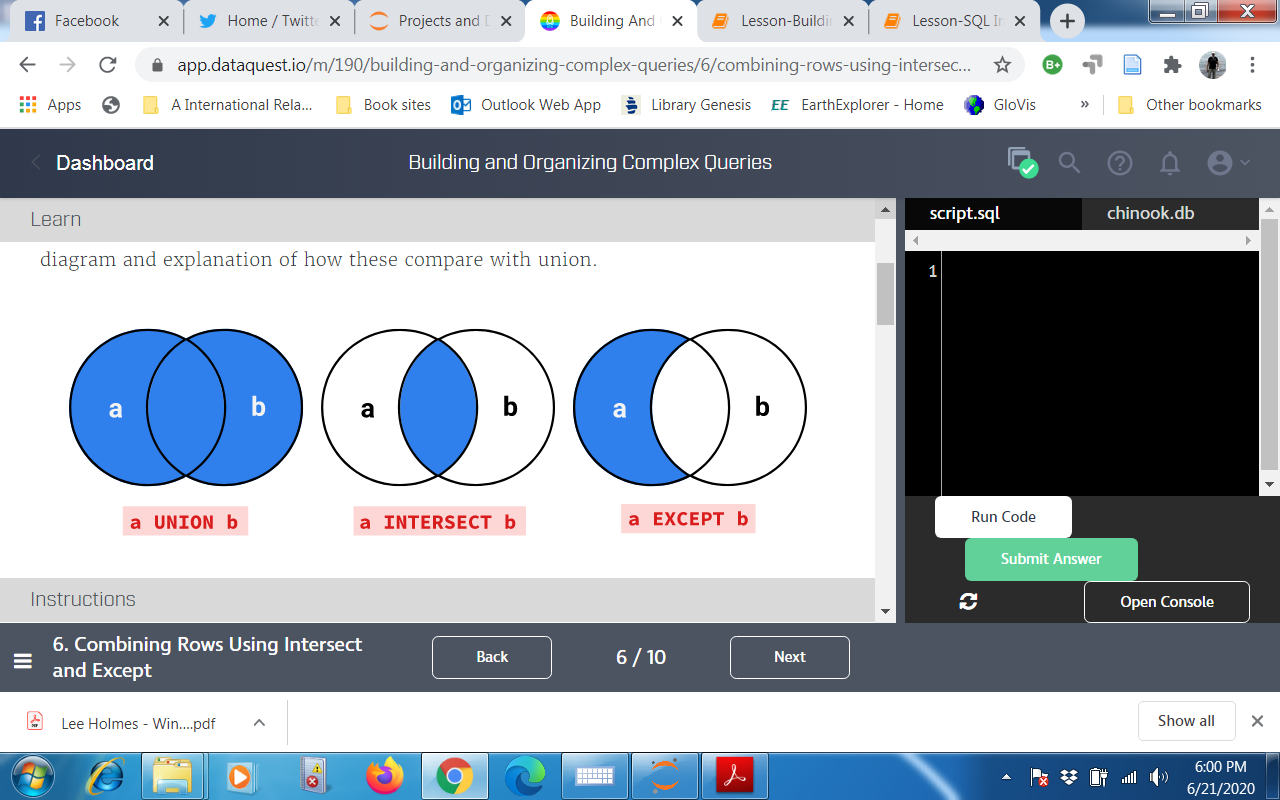

Write a query to identify customers who are in the USA and have spent more than $90 c:

In [9]:
%%sql
SELECT *
  FROM customer_usa

INTERSECT

SELECT *
  FROM customer_gt_90_dollars

   

 * sqlite:///chinook.db
Done.


customer_id,first_name,last_name,company,address,city,state,country,postal_code,phone,fax,email,support_rep_id
17,Jack,Smith,Microsoft Corporation,1 Microsoft Way,Redmond,WA,USA,98052-8300,+1 (425) 882-8080,+1 (425) 882-8081,jacksmith@microsoft.com,5
20,Dan,Miller,None,541 Del Medio Avenue,Mountain View,CA,USA,94040-111,+1 (650) 644-3358,None,dmiller@comcast.com,4
21,Kathy,Chase,None,801 W 4th Street,Reno,NV,USA,89503,+1 (775) 223-7665,None,kachase@hotmail.com,5
22,Heather,Leacock,None,120 S Orange Ave,Orlando,FL,USA,32801,+1 (407) 999-7788,None,hleacock@gmail.com,4


Write a query to identify customers who are in the USA and have not spent more than $90 c:

In [10]:
%%sql
SELECT *
  FROM customer_usa

EXCEPT

SELECT *
  FROM customer_gt_90_dollars

 * sqlite:///chinook.db
Done.


customer_id,first_name,last_name,company,address,city,state,country,postal_code,phone,fax,email,support_rep_id
16,Frank,Harris,Google Inc.,1600 Amphitheatre Parkway,Mountain View,CA,USA,94043-1351,+1 (650) 253-0000,+1 (650) 253-0000,fharris@google.com,4
18,Michelle,Brooks,None,627 Broadway,New York,NY,USA,10012-2612,+1 (212) 221-3546,+1 (212) 221-4679,michelleb@aol.com,3
19,Tim,Goyer,Apple Inc.,1 Infinite Loop,Cupertino,CA,USA,95014,+1 (408) 996-1010,+1 (408) 996-1011,tgoyer@apple.com,3
23,John,Gordon,None,69 Salem Street,Boston,MA,USA,2113,+1 (617) 522-1333,None,johngordon22@yahoo.com,4
24,Frank,Ralston,None,162 E Superior Street,Chicago,IL,USA,60611,+1 (312) 332-3232,None,fralston@gmail.com,3
25,Victor,Stevens,None,319 N. Frances Street,Madison,WI,USA,53703,+1 (608) 257-0597,None,vstevens@yahoo.com,5
26,Richard,Cunningham,None,2211 W Berry Street,Fort Worth,TX,USA,76110,+1 (817) 924-7272,None,ricunningham@hotmail.com,4
27,Patrick,Gray,None,1033 N Park Ave,Tucson,AZ,USA,85719,+1 (520) 622-4200,None,patrick.gray@aol.com,4
28,Julia,Barnett,None,302 S 700 E,Salt Lake City,UT,USA,84102,+1 (801) 531-7272,None,jubarnett@gmail.com,5


The results of `UNION`, `INTERSECT` and `EXCEPT` conform to the 'everything in SQL is a table' concept. The results of these operations can be used in subqueries and joined to other tables for more complex analysis. Let's look at a scenario where we'll need to join the results of a set operation to another table:

Write a query:
- that works out how many customers that are in the USA and have purchased more than $90 are assigned to each sales support agent. 
Result should have the following columns, in order:
- `employee_name` - The first_name and last_name of the employee separated by a space, eg Luke Skywalker.
- `customers_usa_gt_90` - The **number of customer** assigned to that employee that are both from the USA - and have purchased more than $90 worth of tracks.
- The result should include all employees with the title "Sales Support Agent", but not employees with any other title.
Order  results by the `employee_name` column.

In [11]:
%%sql
WITH c AS
        (
         SELECT *
           FROM customer_usa

        INTERSECT

        SELECT *
          FROM customer_gt_90_dollars
        )

SELECT
    e.first_name || " " || e.last_name AS employee_name,
    COUNT(c.customer_id) AS customers_usa_gt_90
  FROM c
      INNER JOIN employee AS e ON e.employee_id=c.support_rep_id  
 WHERE e.title= "Sales Support Agent"
 GROUP BY 1
 ORDER BY 1;

 * sqlite:///chinook.db
Done.


employee_name,customers_usa_gt_90
Margaret Park,2
Steve Johnson,2


**Code below performs the same function as above but gives an additional employee with 0 customers, as a left join (employee:left) has been performed**

In [12]:
%%sql
WITH customers_usa_gt_90 AS
    (
     SELECT * FROM customer_usa

     INTERSECT

     SELECT * FROM customer_gt_90_dollars
    )

SELECT
    e.first_name || " " || e.last_name employee_name,
    COUNT(c.customer_id) customers_usa_gt_90
FROM employee e
LEFT JOIN customers_usa_gt_90 c ON c.support_rep_id  = e.employee_id
WHERE e.title= "Sales Support Agent"
 GROUP BY 1
 ORDER BY 1;


 * sqlite:///chinook.db
Done.


employee_name,customers_usa_gt_90
Jane Peacock,0
Margaret Park,2
Steve Johnson,2


### Multiple Named Subqueries using WITH

Syntax:
```
WITH
    [alias_name] AS ([subquery]),
    [alias_name_2] AS ([subquery_2]),
    [alias_name_3] AS ([subquery_3])

SELECT [main_query]
```
While each subquery can be independent, we can actually use the result of the first subquery in subsequent subqueries, and so on. This can be a useful way of building readable complex queries.

e.g. the query below uses results of preceding subqueries to reduce results:

In [13]:
%%sql
WITH
    usa AS
        (
        SELECT * FROM customer
        WHERE country = "USA"
        ),
    last_name_g AS
        (
         SELECT * FROM usa
         WHERE last_name LIKE "G%"
        ),
    state_ca AS
        (
        SELECT * FROM last_name_g
        WHERE state = "CA"
        )
SELECT
    first_name,
    last_name,
    country,
    state
FROM state_ca;

 * sqlite:///chinook.db
Done.


first_name,last_name,country,state
Tim,Goyer,USA,CA


Write a query:
that uses multiple named subqueries in a `WITH` clause to gather total sales data on customers from India:
- The first named subquery should return all customers that are from India.
- The second named subquery should calculate the sum total for every customer.
- The main query should join the two named subqueries, resulting in the following final columns:
 - `customer_name` - The first_name and last_name of the customer, separated by a space, eg Luke Skywalker.
 - `total_purchases` - The total amount spent on purchases by that customer.
The results should be sorted by the `customer_name` column in alphabetical order.

In [14]:
%%sql
WITH
    india AS
          (
          SELECT * FROM customer
           WHERE country = "India"
          ),
    total AS
        (
         SELECT 
              i.customer_id AS customer_id, 
              SUM(total) AS total
           FROM invoice AS i 
          GROUP BY 1
        )  
SELECT 
     india.first_name || " " || india.last_name AS customer_name,  
     t.total AS total_purchases
  FROM  india 
     LEFT JOIN total AS t ON t.customer_id = india.customer_id
 ORDER BY 1;   

 * sqlite:///chinook.db
Done.


customer_name,total_purchases
Manoj Pareek,111.86999999999999
Puja Srivastava,71.28


### Challenge Query: Each Country's Best Customer

Create a query:
- to find the customer from **each country** that has spent the **most money** at our store, **ordered alphabetically by country**. Query should return the following columns, in order:
- `country` - The name of each country that we have a customer from.
- `customer_name` - The first_name and last_name of the customer from that country with the most total purchases, separated by a space, eg Luke Skywalker.
- `total_purchased` - The total dollar amount that customer has purchased.

It is better to breakdown query in parts and run each part separately before combinining.

1. First, we need to group customers by countries in `customer` table.

In [25]:
%%sql
SELECT 
    country, 
    customer_id,
    first_name || " " || last_name AS customer_name
     
 FROM customer  
 GROUP BY 1, 2
 ORDER BY 1;   

 * sqlite:///chinook.db
Done.


country,customer_id,customer_name
Argentina,56,Diego Gutiérrez
Australia,55,Mark Taylor
Austria,7,Astrid Gruber
Belgium,8,Daan Peeters
Brazil,1,Luís Gonçalves
Brazil,10,Eduardo Martins
Brazil,11,Alexandre Rocha
Brazil,12,Roberto Almeida
Brazil,13,Fernanda Ramos
Canada,3,François Tremblay


2. Second, we have to find total amount spent against each `customer_id` 

In [16]:
%%sql
SELECT 
     customer_id,
     ROUND(SUM(total),2)
  FROM invoice
 GROUP By 1;

 * sqlite:///chinook.db
Done.


customer_id,"ROUND(SUM(total),2)"
1,108.9
2,82.17
3,99.99
4,72.27
5,144.54
6,128.7
7,69.3
8,60.39
9,37.62
10,60.39


3. We join both subqueries

In [36]:
%%sql
SELECT   
     c.customer_id,  
     c.country, 
     c.first_name || " " || c.last_name AS customer_name,
     ROUND(SUM(i.total),2) AS total_purchase 
  FROM customer AS c
                   INNER JOIN invoice AS i ON c.customer_id = i.customer_id
 GROUP BY 1, 2
 ORDER BY 2
; 

 * sqlite:///chinook.db
Done.


customer_id,country,customer_name,total_purchase
56,Argentina,Diego Gutiérrez,39.6
55,Australia,Mark Taylor,81.18
7,Austria,Astrid Gruber,69.3
8,Belgium,Daan Peeters,60.39
1,Brazil,Luís Gonçalves,108.9
10,Brazil,Eduardo Martins,60.39
11,Brazil,Alexandre Rocha,69.3
12,Brazil,Roberto Almeida,82.17
13,Brazil,Fernanda Ramos,106.92
3,Canada,François Tremblay,99.99


In [45]:
%%sql
WITH 
    customer_country_purchases AS 
    (SELECT   
     c.customer_id,  
     c.country AS country, 
     c.first_name || " " || c.last_name AS customer_name,
     ROUND(SUM(i.total),2) AS total_purchase 
  FROM customer AS c
                   INNER JOIN invoice AS i ON c.customer_id = i.customer_id
 GROUP BY 1, 2
 ORDER BY 2),
    
    max_purchases AS
    (SELECT
          ccp.customer_id,
          ccp.country,   
          ccp.customer_name,
          MAX(ccp.total_purchase) AS max_purchase
       FROM customer_country_purchases AS ccp
      GROUP BY 2
    )
SELECT
     mp.country AS country,
     mp.customer_name AS customer_name,
     mp.max_purchase AS total_purchased
  FROM max_purchases AS mp
 ORDER BY 1;
        

 * sqlite:///chinook.db
Done.


country,customer_name,total_purchased
Argentina,Diego Gutiérrez,39.6
Australia,Mark Taylor,81.18
Austria,Astrid Gruber,69.3
Belgium,Daan Peeters,60.39
Brazil,Luís Gonçalves,108.9
Canada,François Tremblay,99.99
Chile,Luis Rojas,97.02
Czech Republic,František Wichterlová,144.54
Denmark,Kara Nielsen,37.62
Finland,Terhi Hämäläinen,79.2


In [42]:
%%sql
SELECT COUNT(DISTINCT(country))
  FROM customer; 

 * sqlite:///chinook.db
Done.


COUNT(DISTINCT(country))
24


In [ ]:
Following overly complicated query gives the same result as the above simple query.

In [44]:
%%sql
WITH
    customer_country_purchases AS
        (
         SELECT
             i.customer_id,
             c.country,
             SUM(i.total) total_purchases
         FROM invoice i
         INNER JOIN customer c ON i.customer_id = c.customer_id
         GROUP BY 1, 2
        ),
    country_max_purchase AS
        (
         SELECT
            country,
             MAX(total_purchases) max_purchase
         FROM customer_country_purchases
         GROUP BY 1
        ),
    country_best_customer AS
        (
         SELECT
            cmp.country,
            cmp.max_purchase,
            (
             SELECT ccp.customer_id
             FROM customer_country_purchases ccp
             WHERE ccp.country = cmp.country AND cmp.max_purchase = ccp.total_purchases
            ) customer_id
            FROM country_max_purchase cmp
        )
SELECT
    cbc.country country,
    c.first_name || " " || c.last_name customer_name,
    cbc.max_purchase total_purchased
FROM customer c
INNER JOIN country_best_customer cbc ON cbc.customer_id = c.customer_id
ORDER BY 1 ASC;

 * sqlite:///chinook.db
Done.


country,customer_name,total_purchased
Argentina,Diego Gutiérrez,39.6
Australia,Mark Taylor,81.18
Austria,Astrid Gruber,69.3
Belgium,Daan Peeters,60.38999999999999
Brazil,Luís Gonçalves,108.89999999999998
Canada,François Tremblay,99.99
Chile,Luis Rojas,97.02000000000001
Czech Republic,František Wichterlová,144.54000000000002
Denmark,Kara Nielsen,37.61999999999999
Finland,Terhi Hämäläinen,79.2
